In [67]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [57]:
def create_instance(K,d):
    X = np.random.normal(size=(K,d))
    theta_star = np.random.normal(size=d)
    optimal_arm = np.argmax(X @ theta_star)
    return X, theta_star, optimal_arm

def regret(arms,optimal_arm,X,theta_star):
    reg = [0]
    opt = np.inner(X[optimal_arm],theta_star)
    for i in range(len(arms)):
        arm = arms[i]
        reg.append(reg[i]+opt-np.inner(X[arm],theta_star))
    return reg

In [292]:
class E2D():
    def __init__(self,X,theta_star,T,sigma,gamma):
        self.X = X
        self.C = 1.01
        self.theta_star = theta_star
        self.T = T
        self.sigma = sigma
        self.gamma = gamma
        self.d = len(theta_star)
        self.K = X.shape[0]
        self.zeros = np.zeros(self.d)
        self.V = np.identity(self.d)
        self.theta = self.zeros
        self.w = self.zeros
        self.mu = np.ones(self.K)/self.K
        self.I = np.identity(self.K)
    
    def reward_function(self,a):
        return np.inner(self.X[a],self.theta_star) + self.sigma*np.random.normal()
        
    
    def update_params(self,a,r):
        self.V = self.V + np.outer(self.X[a],self.X[a])
        self.w = self.w + r*self.X[a]
        self.theta = np.dot(np.linalg.inv(self.V),self.w)
    
    def act(self):
        return np.random.choice(range(self.K),p=self.mu)
    
    def get_weighted(self):
        phi_mu = np.zeros(d)
        V_mu = np.zeros((d,d))
        for a in range(self.K):
            x = self.X[a]
            V_mu += self.mu[a]*np.outer(x,x)
            phi_mu += self.mu[a]*x
        return V_mu,phi_mu
    
    def get_theta_0(self,V_mu,phi_mu):
        theta_0 = np.zeros((self.K,self.d))
        V_inv = np.linalg.inv(V_mu)
        for a in range(self.K):
            theta_0[a] = 1/(2*self.gamma)*np.dot(V_inv,(self.X[a]-phi_mu)) + self.theta
        return theta_0
    
    def norm(self,vec,Matrix):
        return np.sqrt(np.inner(np.dot(vec,Matrix),vec))
    
    def g(self,V_mu,phi_mu,theta,a):
        return np.inner(self.theta, self.X[a] - phi_mu) + 1/(4*self.gamma) \
                * (self.norm(self.X[a]-phi_mu,np.linalg.inv(V_mu))**2)
        #return np.inner(theta,self.X[a]-phi_mu) + self.gamma*self.norm(self.theta-theta,V_mu)**2
    
    def G(self,theta_0,b,a):
        #print(theta_0)
        gap = np.inner(theta_0,self.X[b]) - np.inner(theta_0,self.X[a])
        KL = np.inner(theta_0-self.theta,self.X[a])**2
        return gap - self.gamma*KL
        
    
    def update_mu(self):
        for t in range(1,1000):
            V_mu,phi_mu = self.get_weighted()
            theta_0 = self.get_theta_0(V_mu,phi_mu)
            values = np.zeros(self.K)
            for a in range(self.K):
                values[a] = self.g(V_mu,phi_mu,theta_0[a],a)
            b = np.argmax(values)

            values2 = np.zeros(self.K)
            for a in range(self.K):
                values2[a] = self.G(theta_0[b],b,a)
            a_ = np.argmin(values2)
            self.mu = (1 - 1/(t+2))*self.mu + 1/(t+2)*self.I[a_]
            #print(theta_0)
        
    
    
    def run(self):
        arms = []
        tau = -999
        for t in tqdm(range(self.T)):
            if np.linalg.det(self.V) >= (1+self.C)*tau:
                self.update_mu()
                tau = np.linalg.det(self.V)
            a = int(self.act())
            r = self.reward_function(a)
            arms.append(a)
            self.update_params(a,r)
        return arms
    
    

In [293]:
K = 200
d = 3
sigma = 0.1
X,theta_star,optimal_arm = create_instance(K,d)
T = 2000


In [294]:
gamma = np.sqrt(T)
agent = E2D(X,theta_star,T,sigma,gamma)
arms=agent.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [295]:
reg = regret(arms,optimal_arm,X,theta_star)

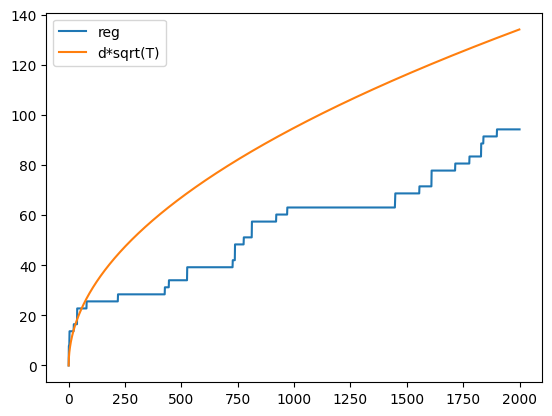

In [296]:
plt.plot(reg,label='reg')
plt.plot(d*np.sqrt(range(T)),label='d*sqrt(T)')
plt.legend()

In [267]:
agent.theta

array([ 1.27259288, -0.70071435,  0.57203683])

In [180]:
theta_star

array([ 0.20236926, -0.29225392,  0.11778417])

array([9.90098058e-05, 9.90099019e-03, 9.10000000e-01, 8.00000000e-02,
       0.00000000e+00])